In [ ]:
# !pip install torch_geometric
# !pip install torchmetrics
# !pip install torch_scatter
# !pip install torch_geometric_temporal
# !pip install networkx==2.5

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict
import os
from typing import *
from torch_geometric.utils.convert import from_networkx
import torch
import torch.nn as nn
import zipfile
from sklearn.metrics import r2_score, mean_squared_error

from models import make_datasets, make_spatio_temporal_edge_index, evaluate_plot, train, test
from models import HistoricalAverageModel, VNNModel, VNNWithDtModel, SpatioTemporalAttention, Ensemble

In [8]:
def make_data(data='PEMSD8'):
    
    Edge_Index = Union[np.ndarray, None]
    Edge_Weight = Union[np.ndarray, None]
    Node_Features = List[Union[np.ndarray, None]]
    Targets = List[Union[np.ndarray, None]]
    Additional_Features = List[np.ndarray]
    
    cwd = os.getcwd()
    
    zip_file_path = os.path.join(cwd, 'data', data + '.zip')
    if os.path.exists(zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.join(cwd, 'data'))
    
    
    TRAVEL_DIST_FILTER = 20
    
    G = nx.readwrite.read_gpickle(os.path.join(cwd, 'data', data, data + '_network32.gpickle'))
    nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})
    base_edge_index = from_networkx(G).edge_index
    
    edges = []
    scale = 5
    spl = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    for node in G.nodes():
        #neighbours within TRAVEL_DIST_FILTER km
        neibs = list(nx.ego_graph(G, radius=TRAVEL_DIST_FILTER, n=node, distance='dist', center=False).nodes)
        edges.extend([(node, x, {'dist': spl[node][x], 'weight': np.exp(-(spl[node][x]/scale)**2)}) for x in neibs])

    G.remove_edges_from(list(G.edges))
    G.add_edges_from(edges)
    
    # Pytorch geometric Data object containing node features
    global net_data
    net_data = from_networkx(G, group_node_attrs=['embedding'], group_edge_attrs=['weight'])
    edge_index = net_data.edge_index
    global obs_nodes
    nodes_scale: List
        
        
    targets = pd.read_csv(os.path.join(cwd, 'data', data, data + '_flows.csv'))
    avg_speed = pd.read_csv(os.path.join(cwd, 'data', data, data + '_speed.csv'))
    features = {'avg_speed': avg_speed}
    time_info = targets['datetime']
    snapshot_features = {'time_feats': time_info}
    targets.drop(columns=['datetime'], inplace=True)
    targets.columns = targets.columns.astype(int)
    obs_nodes = targets.columns.to_list()

    for f in features.values():
        assert time_info.equals(f['datetime'])
        f.drop(columns=['datetime'], inplace=True)
        assert f.shape == targets.shape

    features['avg_speed'].columns = targets.columns

    train_ds, val_ds, test_ds = make_datasets(targets, features, snapshot_features, network_data=net_data)
    
    return train_ds, val_ds, test_ds

def run(model, results, num_epochs=20, lr=1e-3, *args, **kwargs):
    if num_epochs > 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)

        model = train(model, train_ds, val_ds,
            loss_fn, score_fn, optimizer, increasing_score=INCREASING_SCORE, num_epochs=num_epochs, *args, **kwargs)

    test_loss, test_score = test(model, test_ds, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [19]:
# select from ['PEMSD4', 'PEMSD8', 'CZ_highway']

train_ds, val_ds, test_ds = make_data('PEMSD8')

Data(edge_index=[2, 14111], id=[170], dist=[14111], x=[170, 32], edge_attr=[14111, 3])


In [13]:
train_ds[0]

Data(edge_index=[2, 14111], edge_attr=[14111, 3], y=[5, 170], avg_speed=[5, 170], hist_average_y=[5, 170], time_feats=[5, 4])

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
loss_fn = nn.MSELoss().to(device)
SEQ_LEN = 4
# loss_fn = nn.L1Loss().to(device)

score_fn = r2_score
pyg_data = net_data.to(device)

INCREASING_SCORE = True

results = {}

Type: HistoricalAverageModel, Test loss: 0.40, Test score: 0.9049


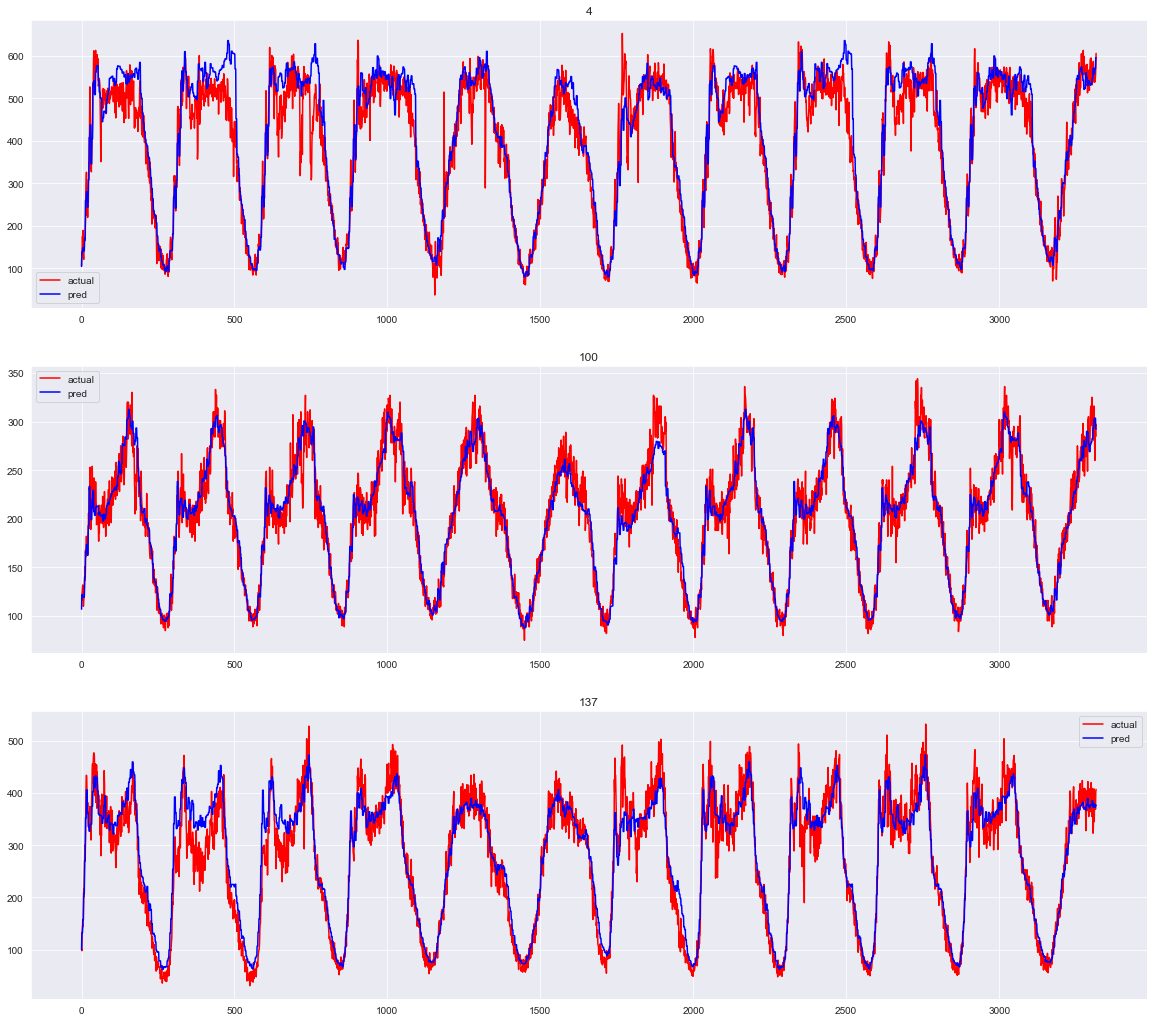

In [15]:
hist_avg = HistoricalAverageModel(seq_len=SEQ_LEN, in_channels=1).to(device)
hist_avg = run(hist_avg, results, num_epochs=0, plot=True, plot_update_freq=5)
evaluate_plot(hist_avg, test_ds, obs_nodes, nodes_num=3)

Type: VNNModel, Test loss: 0.06, Test score: 0.9765


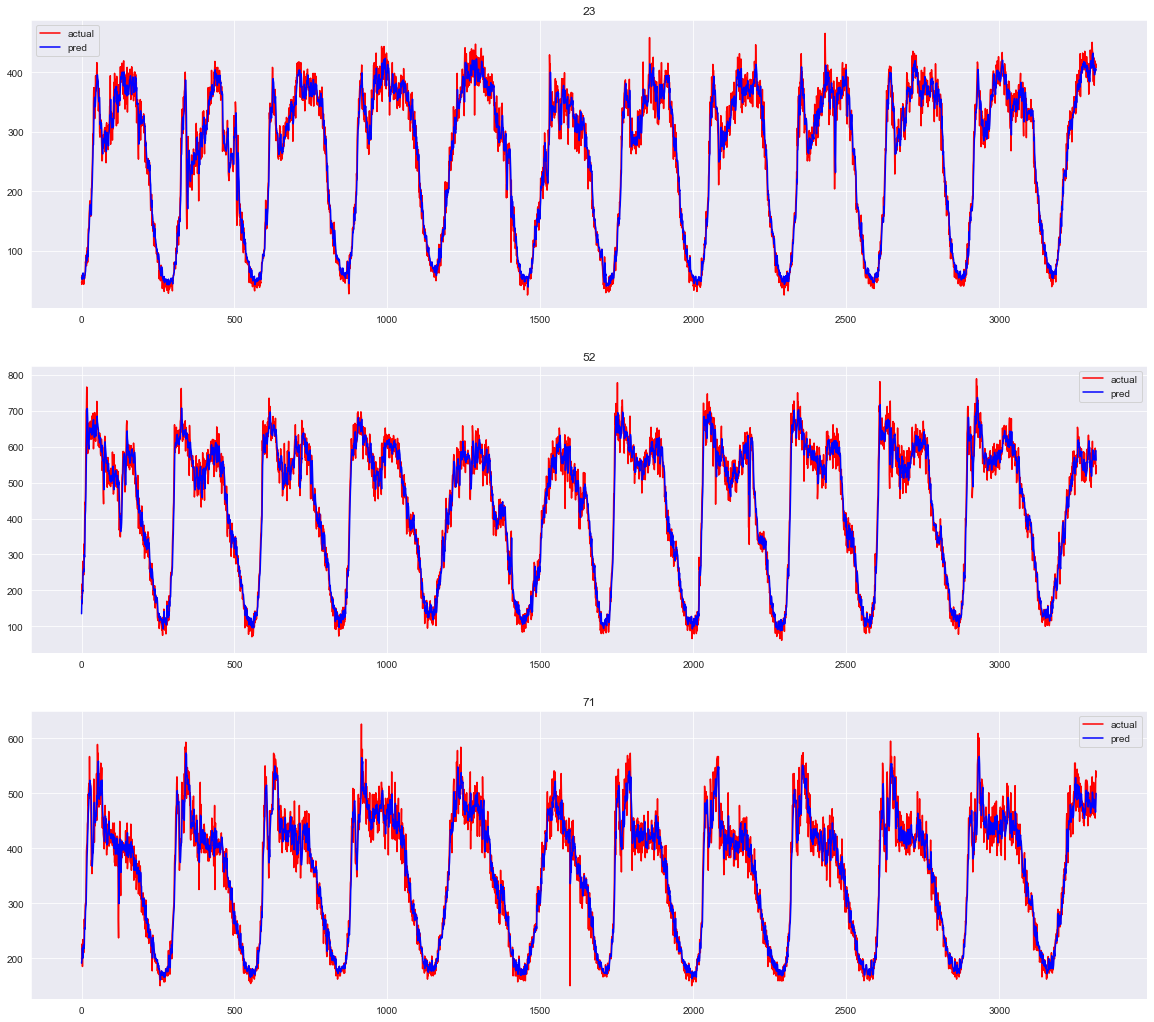

In [16]:
vnn_model = VNNModel(seq_len=SEQ_LEN, in_channels=1).to(device)
vnn_model = run(vnn_model, results, lr=5e-4, num_epochs=1, plot=True, plot_update_freq=2)
evaluate_plot(vnn_model, test_ds, obs_nodes, nodes_num=3)

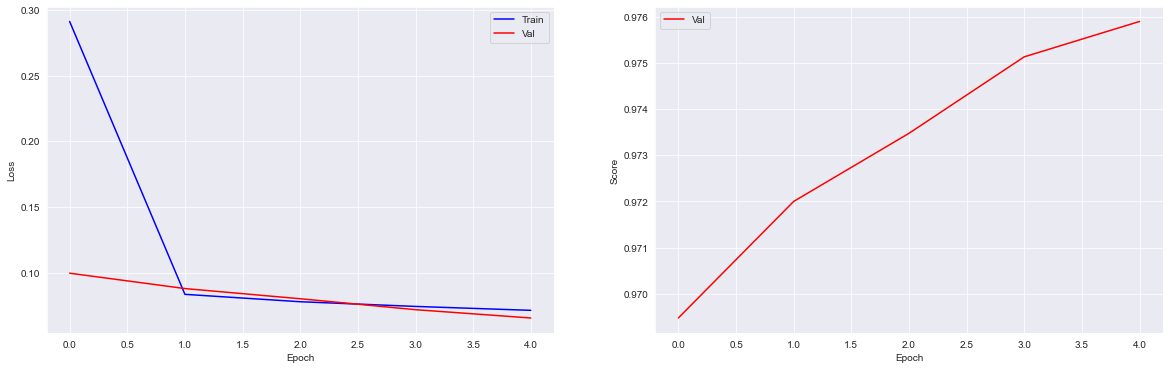

Type: VNNWithDtModel, Test loss: 0.06, Test score: 0.9768


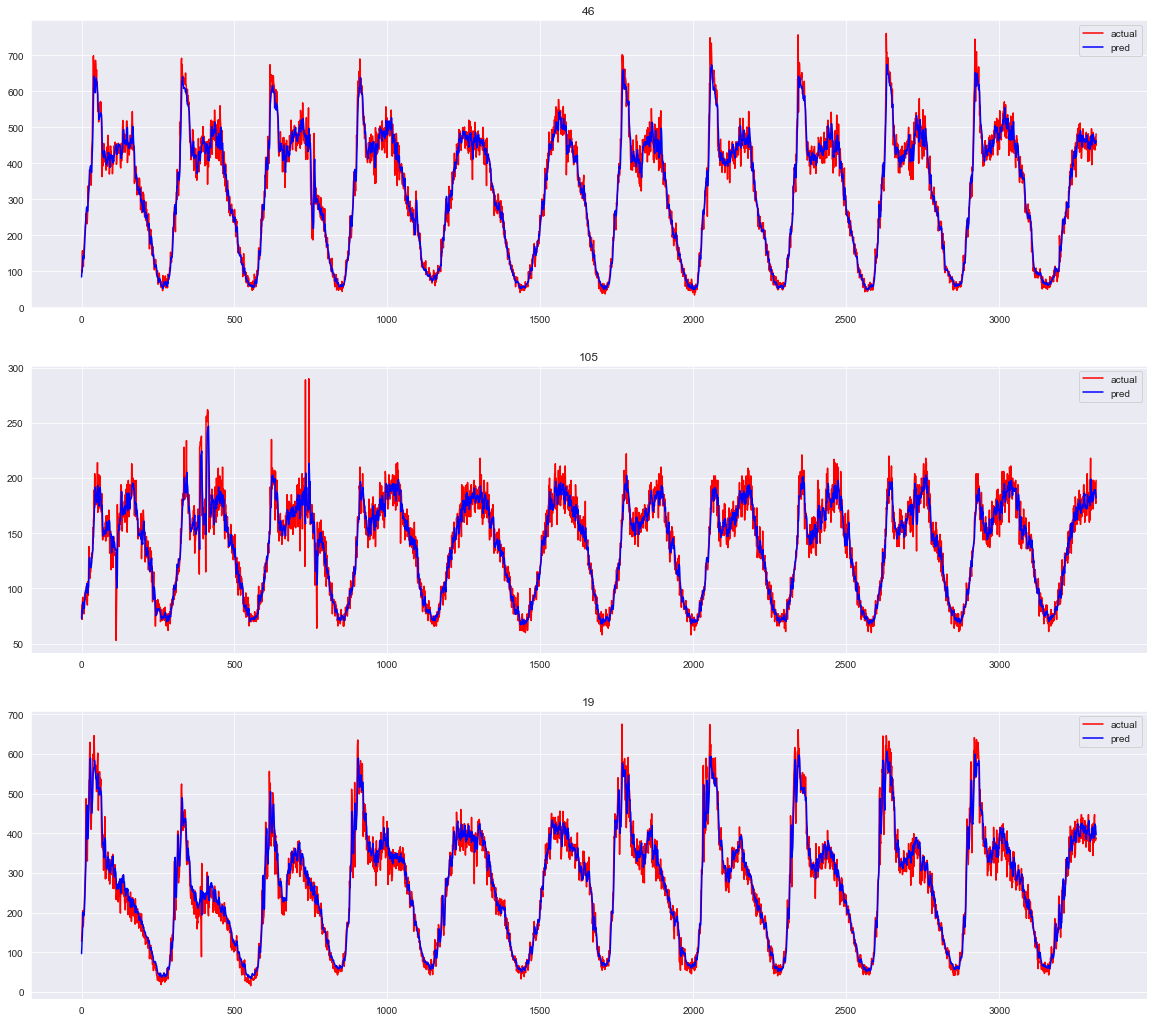

In [17]:
dt_vnn = VNNWithDtModel(seq_len=SEQ_LEN, in_channels=1).to(device)
dt_vnn = run(dt_vnn, results, lr=1e-4, num_epochs=5, plot=True, plot_update_freq=2)
evaluate_plot(dt_vnn, test_ds, obs_nodes, nodes_num=3)

In [ ]:
e, a = make_spatio_temporal_edge_index(SEQ_LEN, net_data.edge_index, net_data.edge_attr)

st_att = SpatioTemporalAttention(seq_len=SEQ_LEN, in_channels=1, 
                                 pyg_data=net_data, e=net_data.edge_index, a=net_data.edge_attr).to(device)
st_att = run(st_att, results, lr=1e-3, num_epochs=1, plot=True, plot_update_freq=1)
evaluate_plot(t_att, test_ds, obs_nodes, nodes_num=3)

In [ ]:
ens = Ensemble(hist_avg, dt_emb, st_att).to(device)
ens = run(ens, results, lr=1e-4, num_epochs=50, plot=True, plot_update_freq=1)